In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow import keras

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
train_data_generator = ImageDataGenerator(rescale = 1./255)

training_set = train_data_generator.flow_from_directory('dataset/train',
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 100000 images belonging to 2 classes.


In [4]:
valid_data_generator = ImageDataGenerator(rescale = 1./255)

valid_set = valid_data_generator.flow_from_directory('dataset/valid',
                                            target_size = (256, 256),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 20000 images belonging to 2 classes.


In [5]:
test_data_generator = ImageDataGenerator(rescale = 1./255)

test_set = test_data_generator.flow_from_directory('dataset/test',
                                            target_size = (256, 256),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 20000 images belonging to 2 classes.


In [6]:
def dfd_image(input_shape, units):
    inception_resnet_v2 = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False,
                                                                                   weights='imagenet', 
                                                                                   input_tensor=None, 
                                                                                   input_shape=input_shape, 
                                                                                   pooling=None, 
                                                                                   classes=1000)
    
    for layer in inception_resnet_v2.layers[:-80]:
        layer.trainable = False
    
    model = tf.keras.Sequential()

    model.add(inception_resnet_v2)
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Flatten())
    
    model.add(Dense(units=128, activation='relu'))
    
    model.add(Dense(units, kernel_regularizer=l2(0.01), activation='linear'))
    
    return model

In [7]:
input_shape = (256, 256, 3)

In [8]:
model = dfd_image(input_shape, units=1)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 54,533,601
Trainable params: 13,166,529
Non-trainable params: 41,367,072
_________________________________________________________________


In [10]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision * recall)/(precision + recall + K.epsilon()))

In [11]:
metrics = ['accuracy', f1_score_m, precision_m, recall_m]

model.compile(optimizer = 'adam',
              loss = 'hinge',
              metrics = metrics)

In [12]:
epochs = 15
callbacks = [keras.callbacks.ModelCheckpoint('Training_checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5')]

In [13]:
history = model.fit(x = training_set, validation_data = valid_set, epochs = epochs, callbacks = callbacks)

Epoch 1/15
3125/3125 [==============================] - 1405s 444ms/step - loss: 0.2264 - accuracy: 0.8978 - f1_score_m: 0.8919 - precision_m: 0.9272 - recall_m: 0.8706 - val_loss: 0.1788 - val_accuracy: 0.9079 - val_f1_score_m: 0.8972 - val_precision_m: 0.9736 - val_recall_m: 0.8372
Epoch 2/15
3125/3125 [==============================] - 1493s 478ms/step - loss: 0.1298 - accuracy: 0.9408 - f1_score_m: 0.9389 - precision_m: 0.9527 - recall_m: 0.9317 - val_loss: 0.0966 - val_accuracy: 0.9517 - val_f1_score_m: 0.9489 - val_precision_m: 0.9762 - val_recall_m: 0.9261
Epoch 3/15
3125/3125 [==============================] - 1519s 486ms/step - loss: 0.0997 - accuracy: 0.9546 - f1_score_m: 0.9536 - precision_m: 0.9644 - recall_m: 0.9476 - val_loss: 0.0946 - val_accuracy: 0.9554 - val_f1_score_m: 0.9533 - val_precision_m: 0.9652 - val_recall_m: 0.9448
Epoch 4/15
3125/3125 [==============================] - 1534s 491ms/step - loss: 0.0792 - accuracy: 0.9640 - f1_score_m: 0.9630 - precision_m: 0.

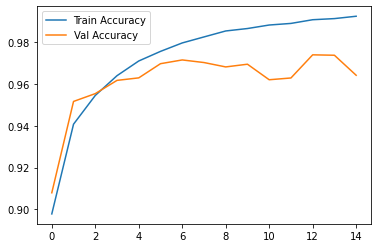

<Figure size 432x288 with 0 Axes>

In [14]:
# plotting the accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()
plt.savefig('Acc and Val_acc1')

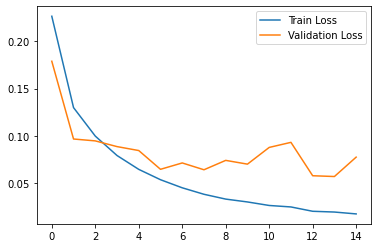

<Figure size 432x288 with 0 Axes>

In [15]:
# plotting the loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('Loss and Val_loss1')

In [16]:
path = 'Weights_Inception_Resnet_SVM/model_weights'
model.save_weights(path)

In [17]:
model.save('Inception_Resnet_SVM_Model/Inception_Resnet_svm_model.h5')

In [18]:
model.evaluate(test_set)

625/625 [==============================] - 228s 365ms/step - loss: 0.0807 - accuracy: 0.9635 - f1_score_m: 0.9610 - precision_m: 0.9903 - recall_m: 0.9357


[0.08072704821825027,
 0.963450014591217,
 0.9609553813934326,
 0.9902809858322144,
 0.9356995224952698]

In [19]:
import cv2

In [51]:
img_path = 'test/00HZSJQ99D.jpg'
img = image.load_img(img_path, target_size=(256, 256))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.image.resize(x, (256,256))
x /= 255
print(x.shape)

(1, 256, 256, 3)


In [52]:
model.predict(x)

array([[-2.8672922]], dtype=float32)